# DEA Intertidal Elevation validation

In [1]:
cd ../..

/home/jovyan/Robbi/dea-intertidal


In [ ]:
pip install -r requirements.in --quiet

In [ ]:
pip install xarray-spatial

In [2]:
%load_ext autoreload
%autoreload 2

import glob 
import rioxarray
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterio.errors import RasterioIOError
import warnings
warnings.filterwarnings("ignore")

import datacube
import odc.geo.xr
from odc.geo.geobox import GeoBox
from odc.geo.geom import BoundingBox, Geometry
from dea_tools.datahandling import load_reproject
from dea_tools.dask import create_local_dask_cluster
from dea_tools.validation import eval_metrics

from intertidal.validation import map_raster, preprocess_validation

config = {
    "db_hostname": "dea-dev-eks-proxy-share.endpoint.proxy-cxhoeczwhtar.ap-southeast-2.rds.amazonaws.com",
    "db_database": "odc",
    "db_username": "sandbox_reader",
    "db_password": "ZWGRrBLmRs9WqTIj",
}
dc = datacube.Datacube(config=config)

client = create_local_dask_cluster(return_client=True)

/env/lib/python3.10/site-packages/datacube/drivers/driver_cache.py:54: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import iter_entry_points
2024-03-19 05:04:44,396 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-y7xtymho', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,Workers: 1
Total threads: 15,Total memory: 117.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45967,Workers: 1
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,Total threads: 15
Started: Just now,Total memory: 117.21 GiB
Comm: tcp://127.0.0.1:46279,Total threads: 15
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/38303/status,Memory: 117.21 GiB
Nanny: tcp://127.0.0.1:45167,


## Validation sites from polygons

In [3]:
# Set up data paths
resampling="average"
resolution=10

# Load polygons
# validation_sites_gdf = gpd.read_file("data/raw/validation_sites_2016.geojson").query("Year == '2016'")
# validation_sites_gdf = pd.concat([gpd.read_file(i) for i in glob.glob("data/raw/validation_sites_*.geojson")]).reset_index(drop=True)
validation_sites_gdf = gpd.read_file("data/raw/validation_sites.geojson")
validation_sites_gdf["mod_path"] = "https://dea-public-data-dev.s3-ap-southeast-2.amazonaws.com/derivative/dea_intertidal/sample_data/virtual_rasters/DEV_2019_2021_elevation.vrt"
validation_sites_gdf["val_path"] = "/gdata1/projects/coastal/intertidal/Elevation_data/Processed/" + validation_sites_gdf.year + "_combined.tif"
# validation_sites_gdf.loc[0, "mod_path"] = "data/processed/ga_s2ls_intertidal_cyear_3/0-0-1/x094/y145/2018--P1Y/ga_s2ls_intertidal_cyear_3_x094y145_2018--P1Y_final_elevation.tif"

# NIDEM comparison
# validation_sites_gdf["mod_path"] = "/gdata1/data/nidem/NIDEM_mosaic.tif"
# resampling="average"
# resolution=25



In [9]:
outputs = []

for i, row in validation_sites_gdf.iterrows():
    print(i)

    try:
        # Convert to Geometry and create GeoBox to load data into
        poly = Geometry(row.geometry, crs="EPSG:4326")
        poly_geobox = odc.geo.geobox.GeoBox.from_geopolygon(
            poly, crs="EPSG:3577", resolution=resolution
        )

        # Load from datacube
        dss = dc.find_datasets(
            product="ga_s2ls_intertidal_cyear_3",
            time="2021",
            like=poly_geobox.compat,
            # intertidal_category="macrotidal",
        )
        tr = np.mean([i.metadata.search_fields["intertidal_tr"] for i in dss])
        otr = np.mean([i.metadata.search_fields["intertidal_otr"] for i in dss])
        lat = np.mean([i.metadata.search_fields["intertidal_lat"] for i in dss])
        hat = np.mean([i.metadata.search_fields["intertidal_hat"] for i in dss])

        modelled_ds = (
            dc.load(
                datasets=dss,
                like=poly_geobox.compat,
                measurements=["elevation", "uncertainty"],
                dask_chunks={"x": 2024, "y": 2048},
                resampling=resampling,
            )
            .squeeze("time")
            .compute()
        )
        modelled_da = modelled_ds.elevation
        uncertainty_da = modelled_ds.uncertainty

        # modelled_ds = dc.load(
        #             product="nidem",
        #             like=poly_geobox.compat,
        #             dask_chunks={"x": 2048, "y": 2048},
        #             resampling=resampling,
        #         ).squeeze("time")
        # modelled_da = modelled_ds.nidem.compute()
        # modelled_da = modelled_da.where(modelled_da > -10)

        # Skip polygon if no modelled data available
        if (~modelled_da.isnull()).sum().item() > 0:
            # Load validation data into polygon GeoBox
            validation_da = load_reproject(
                path=row.val_path, how=poly_geobox, resampling=resampling
            ).compute()
            
            # Mask to between LAT and HAT
            validation_da = validation_da.where((validation_da >= lat) & (validation_da <= hat))

            # Mask our data by our input polygon
            modelled_da = modelled_da.odc.mask(poly=poly)

            # Preprocess
            validation_m, modelled_m, uncertainty_m = preprocess_validation(
                modelled_da, validation_da, uncertainty_da
            )

            output_df = pd.DataFrame(
                {
                    "i": i,
                    "year": row.year,
                    "tr": tr,
                    "otr": otr,
                    "lat": lat,
                    "hat": hat,
                    "validation_m": validation_m,
                    "modelled_m": modelled_m,
                    "uncertainty_m": uncertainty_m,
                }
            )
            outputs.append(output_df)

    except (KeyError, RasterioIOError, IndexError, AssertionError):
        pass

# Combine and add additional columns
outputs_all_df = pd.concat(outputs)
outputs_all_df["uncertainty_perc"] = outputs_all_df.uncertainty_m / outputs_all_df.tr
outputs_all_df["category"] = pd.cut(
    outputs_all_df.tr,
    bins=(0, 2, 4, np.inf),
    labels=["microtidal", "mesotidal", "macrotidal"],
)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
# test = outputs_all_df.groupby("i").first()

In [ ]:
# test["category"] = test.category.astype(str)

In [ ]:
# validation_sites_gdf.join(test).to_file("test.geojson")

In [1]:
# Plot and compare - heatmap
plt.figure(figsize=(5, 5))
lim_min, lim_max = np.percentile(
    np.concatenate([outputs_all_df.validation_m, outputs_all_df.modelled_m]), [1, 99]
)
lim_min -= 1
lim_max += 1
plt.hexbin(
    x=outputs_all_df.validation_m,
    y=outputs_all_df.modelled_m,
    extent=(lim_min, lim_max, lim_min, lim_max),
    cmap="inferno",
    # bins="log",
)
plt.gca().set_facecolor("#0C0C0C")
plt.plot([lim_min, lim_max], [lim_min, lim_max], "--", c="white")
plt.margins(x=0, y=0)
plt.xlabel("LiDAR DEM (m)")
plt.ylabel("Intertidal DEM (m)")

# Accuracy statistics
print(eval_metrics(x=outputs_all_df.validation_m, y=outputs_all_df.modelled_m, round=3))
print(f"{len(outputs_all_df.modelled_m) * (10 * 10) * 0.000001:.2f} km sq")


NameError: name 'plt' is not defined

In [ ]:
import seaborn as sns

sns.kdeplot(
    x=outputs_all_df.validation_m,
    y=outputs_all_df.modelled_m,
    cmap="inferno",
    fill=True,
    thresh=0,
    bw_adjust=0.4,
    levels=30,
)

Correlation         0.916
RMSE                0.262
MAE                 0.202
R-squared           0.839
Bias                0.146
Regression slope    0.891
dtype: float64
Correlation         0.794
RMSE                0.297
MAE                 0.223
R-squared           0.630
Bias                0.144
Regression slope    0.713
dtype: float64
Correlation         0.633
RMSE                0.374
MAE                 0.286
R-squared           0.401
Bias                0.053
Regression slope    0.528
dtype: float64


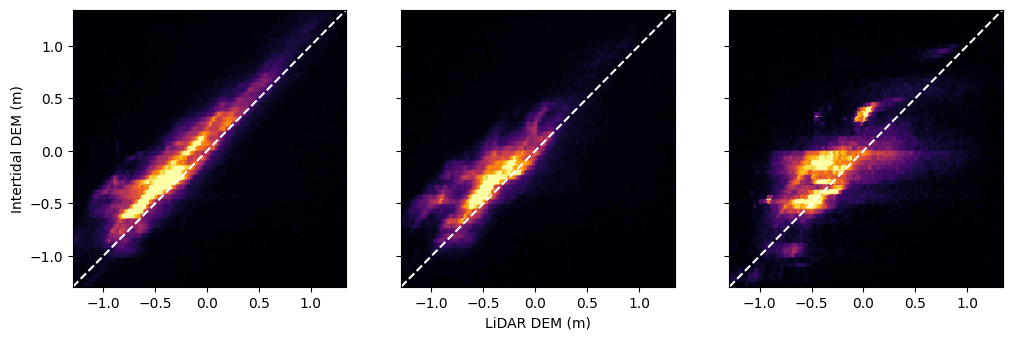

In [23]:
lim_min, lim_max = np.percentile(
    np.concatenate([outputs_all_df.validation_m, outputs_all_df.modelled_m]), [1, 99]
)
lim_min -= 0.1
lim_max += 0.1

fig, axes = plt.subplots(1, 3, figsize=(12, 3.6), sharex=True, sharey=True)

# Define a set of certainty ranges
cert_ranges = [(0, 0.1), (0.1, 0.2), (0.2, 1.0)]

out = {}
for i, (min_thresh, max_thresh) in enumerate(cert_ranges):
    outputs_subset_df = outputs_all_df.query(
        "(uncertainty_perc >= @min_thresh) & (uncertainty_perc < @max_thresh)"
    )

    # Plot and compare - heatmap
    axes[i].hexbin(
        x=outputs_subset_df.validation_m,
        y=outputs_subset_df.modelled_m,
        extent=(lim_min, lim_max, lim_min, lim_max),
        cmap="inferno",
        bins=100,
        vmin=0,
        vmax=50,
        # edgecolors="face",
    )
    axes[i].plot([lim_min, lim_max], [lim_min, lim_max], "--", c="white")
    axes[i].margins(x=0, y=0)
    if i == 0:
        axes[i].set_ylabel("Intertidal DEM (m)")
    elif i == 1:
        axes[i].set_xlabel("LiDAR DEM (m)")

    # Accuracy statistics
    print(
        eval_metrics(
            x=outputs_subset_df.validation_m, y=outputs_subset_df.modelled_m, round=3
        )
    )

In [ ]:
import matplotlib.colors

Correlation         0.526
RMSE                0.285
MAE                 0.214
R-squared           0.276
Bias                0.086
Regression slope    0.385
dtype: float64
Correlation         0.837
RMSE                0.281
MAE                 0.213
R-squared           0.701
Bias                0.142
Regression slope    0.742
dtype: float64
Correlation         0.926
RMSE                0.325
MAE                 0.250
R-squared           0.858
Bias                0.149
Regression slope    1.003
dtype: float64


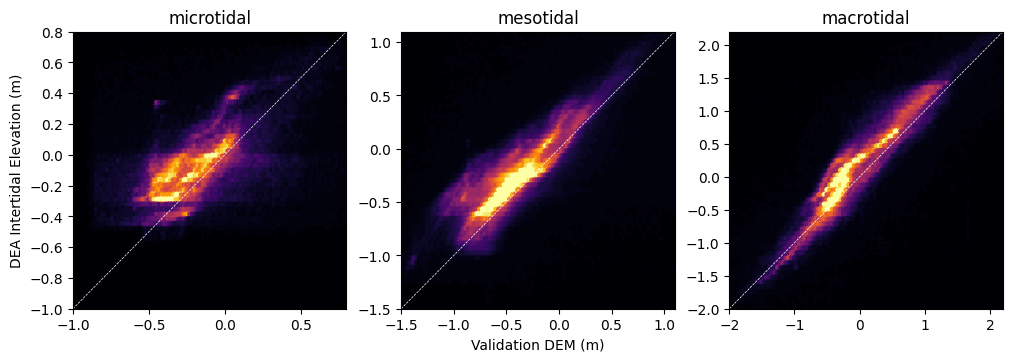

In [32]:


fig, axes = plt.subplots(1, 3, figsize=(12, 3.6))  #, sharex=True, sharey=True)

# Define a set of certainty ranges
cat_ranges = ["microtidal", "mesotidal", "macrotidal"] 

scale_dict = {"microtidal": (-1, 0.8), "mesotidal": (-1.5, 1.1), "macrotidal": (-2, 2.2)}

out = {}
for i, cat in enumerate(cat_ranges):
    outputs_subset_df = outputs_all_df.query("category == @cat")
    
#     lim_min, lim_max = np.percentile(
#     np.concatenate([outputs_subset_df.validation_m, outputs_subset_df.modelled_m]), [1, 99]
# )
#     lim_min -= 1
#     lim_max += 1
    lim_min, lim_max = scale_dict[cat]

    # Plot and compare - heatmap
    axes[i].hexbin(
        x=outputs_subset_df.validation_m,
        y=outputs_subset_df.modelled_m,
        extent=(lim_min, lim_max, lim_min, lim_max),
        cmap="inferno",
        bins=100,
        vmin=0,
        vmax=50,
        # mincnt=5,
        # bins="log",
    )
    axes[i].set_facecolor("#0C0C0C")
    axes[i].plot([lim_min, lim_max], [lim_min, lim_max], "--", c="white", linewidth=0.5)
    axes[i].margins(x=0, y=0)
    axes[i].set_title(cat)
    if i == 0:
        axes[i].set_ylabel("DEA Intertidal Elevation (m)")
    elif i == 1:
        axes[i].set_xlabel("Validation DEM (m)")

    # Accuracy statistics
    print(
        eval_metrics(
            x=outputs_subset_df.validation_m, y=outputs_subset_df.modelled_m, round=3
        )
    )

In [36]:
outputs_all_df["error"] = outputs_all_df["modelled_m"] - outputs_all_df["validation_m"] 

In [39]:
# outputs_all_df

In [43]:
outputs_all_df.error.abs()

0         0.229138
1         0.049585
2         0.309727
3         0.303699
4         0.085394
            ...   
559704    0.080846
559705    0.492196
559706    0.401029
559707    0.285646
559708    0.299316
Name: error, Length: 3212097, dtype: float32

Text(0, 0.5, 'Absolute errors (m)')

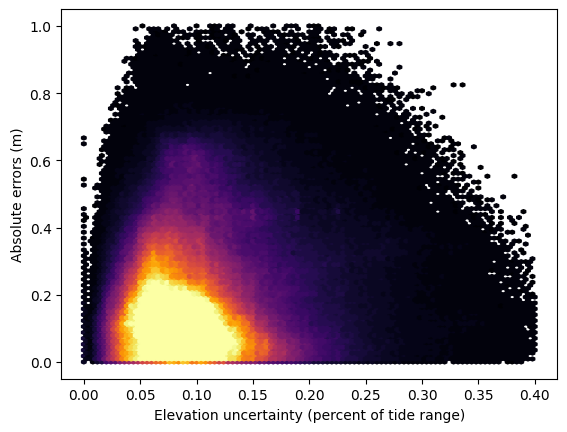

In [60]:
plt.hexbin(
        x=outputs_all_df.uncertainty_perc,
        y=outputs_all_df.error.abs(),
        extent=(0, 0.4, 0, 1),
        cmap="inferno",
        bins=100,
        # vmin=0,
        vmax=50,
        mincnt=10,
        # bins="log",
    )
plt.xlabel("Elevation uncertainty (percent of tide range)")
plt.ylabel("Absolute errors (m)")

In [ ]:
plt.hexbin(
        x=outputs_all_df.uncertainty_m,
        y=outputs_all_df.error.abs(),
        extent=(0, 0.4, 0, 1),
        cmap="inferno",
        bins=100,
        # vmin=0,
        vmax=50,
        mincnt=10,
        # bins="log",
    )
plt.xlabel("Elevation uncertainty (percent of tide range)")
plt.ylabel("Absolute errors (m)")

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(12, 2), sharex=True, sharey=True)

# Define a set of certainty ranges
cert_ranges = [(0, 0.1), (0.1, 0.2), (0.2, 0.5), (0.5, 1.0)]

out = {}
for i, (min_thresh, max_thresh) in enumerate(cert_ranges):
    
    # Extract subset of modelled elevation according to certainty range
    modelled_ds_subset = modelled_ds.where(
        (uncertainty_ds >= min_thresh) * (uncertainty_ds < max_thresh)
    )

    # Preprocess
    validation_z, modelled_z = preprocess_validation(
        modelled_ds_subset, validation_ds, None
    )

    # Compute accuracy metrics
    certainty_str = f"{min_thresh}-{max_thresh}"
    out[certainty_str] = eval_metrics(
        x=validation_z, y=modelled_z, round=3
    )
    
    # Plot heatmaps
    axes[i].hexbin(
    x=validation_z,
    y=modelled_z,
    extent=(lim_min, lim_max, lim_min, lim_max),
    cmap="inferno",
)
    axes[i].plot([lim_min, lim_max], [lim_min, lim_max], "--", c="white")
    axes[i].margins(x=0, y=0)
    axes[i].set_title(f"Certainty: {certainty_str} m")
    if i == 2:
        axes[i].set_xlabel("LiDAR DEM (m)")
    if i == 0:
        axes[i].set_ylabel("Intertidal DEM (m)")

# Combine into a single dataframe
combined_df = pd.concat(out, axis=1)
combined_df.T.plot()
plt.gca().set_title("Accuracy statistics by certainty")
print(combined_df)

In [ ]:
validation_all = np.concatenate(validation_zs)
modelled_all = np.concatenate(modelled_zs)

# Plot and compare - heatmap
plt.figure(figsize=(5, 5))
lim_min, lim_max = np.percentile(
    np.concatenate([validation_all, modelled_all]), [1, 99]
)
lim_min -= 0.1
lim_max += 0.1
plt.hexbin(
    x=validation_all,
    y=modelled_all,
    extent=(lim_min, lim_max, lim_min, lim_max),
    cmap="inferno",
)
plt.plot([lim_min, lim_max], [lim_min, lim_max], "--", c="white")
plt.margins(x=0, y=0)
plt.xlabel("LiDAR DEM (m)")
plt.ylabel("Intertidal DEM (m)")

# Accuracy statistics
print(eval_metrics(x=validation_all, y=modelled_all, round=3))
print(f"{len(modelled_all) * (10 * 10) * 0.000001} km sq")

In [ ]:
validation_all = np.concatenate(validation_zs)
modelled_all = np.concatenate(modelled_zs)

# Plot and compare - heatmap
plt.figure(figsize=(5, 5))
lim_min, lim_max = np.percentile(
    np.concatenate([validation_all, modelled_all]), [1, 99]
)
lim_min -= 0.1
lim_max += 0.1
plt.hexbin(
    x=validation_all,
    y=modelled_all,
    extent=(lim_min, lim_max, lim_min, lim_max),
    cmap="inferno",
)
plt.plot([lim_min, lim_max], [lim_min, lim_max], "--", c="white")
plt.margins(x=0, y=0)
plt.xlabel("LiDAR DEM (m)")
plt.ylabel("Intertidal DEM (m)")

# Accuracy statistics
print(eval_metrics(x=validation_all, y=modelled_all, round=3))
print(f"{len(modelled_all) * (10 * 10) * 0.000001} km sq")

In [ ]:
validation_all = np.concatenate(validation_zs)
modelled_all = np.concatenate(modelled_zs)

# Plot and compare - heatmap
plt.figure(figsize=(5, 5))
lim_min, lim_max = np.percentile(
    np.concatenate([validation_all, modelled_all]), [2, 98]
)
lim_min -= 0.2
lim_max += 0.2
plt.hexbin(
    x=validation_all,
    y=modelled_all,
    extent=(lim_min, lim_max, lim_min, lim_max),
    cmap="inferno",
)
plt.plot([lim_min, lim_max], [lim_min, lim_max], "--", c="white")
plt.margins(x=0, y=0)
plt.xlabel("LiDAR DEM (m)")
plt.ylabel("Intertidal DEM (m)")

# Accuracy statistics
print(eval_metrics(x=validation_all, y=modelled_all, round=3))
print(f"{len(modelled_all) * (10 * 10) * 0.000001} km sq")

## Individual validations

#### NT LiDAR

In [ ]:
# Setup
val_path = "data/raw/lidar_10m.tif"
mod_path = "https://dea-public-data-dev.s3-ap-southeast-2.amazonaws.com/derivative/dea_intertidal/sample_data/virtual_rasters/DEV_2019_2021_elevation.vrt"
unc_path = "https://dea-public-data-dev.s3-ap-southeast-2.amazonaws.com/derivative/dea_intertidal/sample_data/virtual_rasters/DEV_2019_2021_elevation_uncertainty.vrt"
resampling = "average"

# Load LIDAR validation data
validation_ds = (
    rioxarray.open_rasterio(val_path, masked=True)
    .squeeze("band")
    .sel(x=slice(623294, 720470), y=slice(8275633, 8214379))
)
validation_ds.name = "validation_ds"

# Load modelled elevation and uncertainty data
modelled_ds = load_reproject(
    path=mod_path,
    gbox=validation_ds.odc.geobox,
    name="modelled_ds",
    resampling=resampling,
)
uncertainty_ds = load_reproject(
    path=unc_path,
    gbox=validation_ds.odc.geobox,
    name="uncertainty_ds",
    resampling=resampling,
)

#### Testing tiles

In [ ]:
# Setup
val_path = "data/raw/lidar_10m.tif"
mod_path1 = f"data/interim/x99y118/2019-2021/x99y118_2019_2021_elevation.tif"
mod_path2 = f"data/interim/x98y118/2019-2021/x98y118_2019_2021_elevation.tif"
mod_path3 = f"data/interim/x100y117/2019-2021/x100y117_2019_2021_elevation.tif"
mod_path4 = f"data/interim/x99y117/2019-2021/x99y117_2019_2021_elevation.tif"
# mod_path1 = f"data/interim/x99y118/2019-2021-spearman/x99y118_2019_2021_elevation_uncertainty.tif"
# mod_path2 = f"data/interim/x98y118/2019-2021-spearman/x98y118_2019_2021_elevation_uncertainty.tif"
# mod_path3 = f"data/interim/x100y117/2019-2021-spearman/x100y117_2019_2021_elevation_uncertainty.tif"
# mod_path4 = f"data/interim/x99y117/2019-2021-spearman/x99y117_2019_2021_elevation_uncertainty.tif"
resampling = "average"

# Load LIDAR validation data
validation_ds = (
    rioxarray.open_rasterio(val_path, masked=True)
    .squeeze("band")
    .sel(x=slice(623294, 720470), y=slice(8275633, 8214379))
)
validation_ds.name = "validation_ds"

# Load modelled elevation and uncertainty data
modelled_ds1 = load_reproject(
    path=mod_path1,
    gbox=validation_ds.odc.geobox,
    name="modelled_ds",
    resampling=resampling,
    dst_nodata=np.nan,
)
modelled_ds2 = load_reproject(
    path=mod_path2,
    gbox=validation_ds.odc.geobox,
    name="modelled_ds",
    resampling=resampling,
    dst_nodata=np.nan,
)
modelled_ds3 = load_reproject(
    path=mod_path3,
    gbox=validation_ds.odc.geobox,
    name="modelled_ds",
    resampling=resampling,
    dst_nodata=np.nan,
)
modelled_ds4 = load_reproject(
    path=mod_path4,
    gbox=validation_ds.odc.geobox,
    name="modelled_ds",
    resampling=resampling,
    dst_nodata=np.nan,
)
modelled_ds = (
    modelled_ds1.combine_first(modelled_ds2)
    .combine_first(modelled_ds3)
    .combine_first(modelled_ds4)
)

In [ ]:
# modelled_ds.plot.imshow()

#### Moreton Bay SDB

In [ ]:
# Setup
val_path = "data/raw/SDB_AUS_MoretonBay_EOMAP_20220808_20230414_3m_MSL_geotiff.tif"
mod_path = "https://dea-public-data-dev.s3-ap-southeast-2.amazonaws.com/derivative/dea_intertidal/sample_data/virtual_rasters/DEV_2019_2021_elevation.vrt"
unc_path = "https://dea-public-data-dev.s3-ap-southeast-2.amazonaws.com/derivative/dea_intertidal/sample_data/virtual_rasters/DEV_2019_2021_elevation_uncertainty.vrt"
resampling = "average"

# Set geobox for specific bounding box
bbox = BoundingBox(2050863, -3186980, 2091372, -3070780, crs="EPSG:3577")
bbox = BoundingBox(2054949, -3158856, 2090075, -3130736, crs="EPSG:3577")
gbox = GeoBox.from_bbox(bbox, resolution=10)

# Load SDB as validation data
validation_ds = load_reproject(
    path=val_path, gbox=gbox, name="validation_ds", resampling=resampling
)

# Load modelled elevation and uncertainty data
modelled_ds = load_reproject(
    path=mod_path,
    gbox=validation_ds.odc.geobox,
    name="modelled_ds",
    resampling=resampling,
)
uncertainty_ds = load_reproject(
    path=unc_path,
    gbox=validation_ds.odc.geobox,
    name="uncertainty_ds",
    resampling=resampling,
)

### Plot layers

In [ ]:
# Calculate difference
diff_ds = validation_ds - modelled_ds
diff_ds = diff_ds.odc.assign_crs(modelled_ds.odc.crs)
diff_ds.name = "difference"

# Plot both layers
map_raster(
    [validation_ds, modelled_ds, diff_ds],
    vmin=[-10.0, -10.0, -1.0],
    vmax=[0.5, 0.5, 1.0 ],
    cmap=["viridis", "viridis", "RdBu"],
)

#### Validate modelled elevation against validation elevation

In [ ]:
# Preprocess
validation_z, modelled_z = preprocess_validation(modelled_ds-0.18, validation_ds, None)

# Plot and compare - heatmap
plt.figure(figsize=(5, 5))
lim_min, lim_max = np.percentile(np.concatenate([validation_z, modelled_z]), [1, 99])
lim_min -= 0.2
lim_max += 0.2
plt.hexbin(
    x=validation_z,
    y=modelled_z,
    extent=(lim_min, lim_max, lim_min, lim_max),
    cmap="inferno",
)
plt.plot([lim_min, lim_max], [lim_min, lim_max], "--", c="white")
plt.margins(x=0, y=0)
plt.xlabel("LiDAR DEM (m)")
plt.ylabel("Intertidal DEM (m)")

# Accuracy statistics
eval_metrics(x=validation_z, y=modelled_z, round=3)

#### Compare elevation accuracy by uncertainty

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(12, 2), sharex=True, sharey=True)

# Define a set of certainty ranges
cert_ranges = [(0, 0.25), (0.25, 0.5), (0.5, 0.75), (0.75, 1.0), (1.0, 10.0)]

out = {}
for i, (min_thresh, max_thresh) in enumerate(cert_ranges):
    
    # Extract subset of modelled elevation according to certainty range
    modelled_ds_subset = modelled_ds.where(
        (uncertainty_ds >= min_thresh) * (uncertainty_ds < max_thresh)
    )

    # Preprocess
    validation_z, modelled_z = preprocess_validation(
        modelled_ds_subset, validation_ds, None
    )

    # Compute accuracy metrics
    certainty_str = f"{min_thresh}-{max_thresh}"
    out[certainty_str] = eval_metrics(
        x=validation_z, y=modelled_z, round=3
    )
    
    # Plot heatmaps
    axes[i].hexbin(
    x=validation_z,
    y=modelled_z,
    extent=(lim_min, lim_max, lim_min, lim_max),
    cmap="inferno",
)
    axes[i].plot([lim_min, lim_max], [lim_min, lim_max], "--", c="white")
    axes[i].margins(x=0, y=0)
    axes[i].set_title(f"Certainty: {certainty_str} m")
    if i == 2:
        axes[i].set_xlabel("LiDAR DEM (m)")
    if i == 0:
        axes[i].set_ylabel("Intertidal DEM (m)")

# Combine into a single dataframe
combined_df = pd.concat(out, axis=1)
combined_df.T.plot()
plt.gca().set_title("Accuracy statistics by certainty")
print(combined_df)